In [1]:
#hide
%load_ext autoreload
%autoreload 2

In [5]:
import yaml
from nbdev.showdoc import *
from IPython.display import Markdown,display
import nb2ltx.klauswert as test

#export
class AppConfig():
    def __init__(self, file_name):
        with open(file_name) as f:
            self.config = yaml.safe_load(f)
        self.database_user = self.config["database_user"]
        self.database_password = self.config["database_password"]
        self.database_name = self.config["database_name"]
        self.database_host = self.config["database_host"]
        self.database_port = self.config["database_port"]
        self.table_index_values_name = self.config["table_index_values_name"]
        self.data_file_folder = self.config["data_file_folder"]
        
class DataFileContainer():
    def __init__(self, file_name):
        with open(file_name) as f:
            self.yaml_file = yaml.safe_load(f)
        self.index_value_files = self.yaml_file["index_data"]

ModuleNotFoundError: No module named 'nb2ltx'

In [321]:
#hide
#from nbdev.showdoc import *
from IPython.display import Markdown,display
#import nb2ltx.AppConfig as AppConfig
import pyorient
import pandas as pd
import os.path
import matplotlib.pyplot as plt
import datetime as dt
import xlrd
import numpy as np
from collections import defaultdict
import operator

In [322]:
config = AppConfig("config.yml")

In [323]:
client = pyorient.OrientDB(config.database_host, config.database_port)
client.connect(config.database_user, config.database_password)

15

In [324]:
if client.db_exists(config.database_name):
   # Drop Database
   client.db_drop(config.database_name)
    
# Create Database
client.db_create(
  config.database_name,
  pyorient.DB_TYPE_DOCUMENT,
  pyorient.STORAGE_TYPE_PLOCAL 
)

database = client.db_open(config.database_name, config.database_user, config.database_password)

In [325]:
client.command("CREATE CLASS " + config.table_index_values_name + " IF NOT EXISTS")
client.command("CREATE PROPERTY " + config.table_index_values_name + ".Date DATE")
client.command("CREATE PROPERTY " + config.table_index_values_name + ".ISIN STRING")
client.command("CREATE INDEX isinDate ON " + config.table_index_values_name + " (ISIN, Date) UNIQUE")

[0]

In [326]:
def prepare_index_data(df, isin, region):
    df.columns = df.columns.str.replace(' ','_')
    df.dropna(inplace = True)
    df["ISIN"] = isin
    df["Region"] = region
    
def insert_index_data(index_value_file_list):
    current_index = 1
    for file in index_value_file_list:
        df = pd.read_csv(os.path.join(config.data_file_folder, file["file_name"]))
        prepare_index_data(df, file["isin"], file["region"])
        print("Inserting '" + file["file_name"] + "' (" + str(current_index) + " of " + str(len(index_value_file_list)) + ") (" + str(df.shape[0]) + " rows) ...")
        current_index = current_index + 1
        for index, row in df.iterrows():
            insert_command = "INSERT INTO " + config.table_index_values_name + " CONTENT " + row.to_json()
            client.command(insert_command)

In [327]:
data_file_container = DataFileContainer("files.yml")

In [328]:
print("-- Inserting index values")
insert_index_data(data_file_container.index_value_files)
print("-- Done!")

-- Inserting index values
Inserting 'Index CAC40 (FCHI) Entwicklung.csv' (1 of 7) (7905 rows) ...
Inserting 'Index DAX Entwicklung.csv' (2 of 7) (8443 rows) ...
Inserting 'Index Dow Jones (DJI) Entwicklung.csv' (3 of 7) (5346 rows) ...
Inserting 'Index Euronext 100 (N100) Entwicklung.csv' (4 of 7) (5451 rows) ...
Inserting 'Index NASDAQ100 (NDX) Entwicklung.csv' (5 of 7) (5366 rows) ...
Inserting 'Index S&P500 Entwicklung.csv' (6 of 7) (5366 rows) ...
Inserting 'Index STOXX50E Entwicklung seit 2007.csv' (7 of 7) (3526 rows) ...
-- Done!


In [329]:
# Test query
print(client.query("SELECT FROM " + config.table_index_values_name, 10)[0])

{'@index_value':{'Date': datetime.date(1990, 3, 1), 'Open': 1836.0, 'High': 1838.0, 'Low': 1827.0, 'Close': 1832.0, 'Adj_Close': 1832.0, 'Volume': 0.0, 'ISIN': 'FR0003500008', 'Region': 'EU'},'version':1,'rid':'#25:0'}


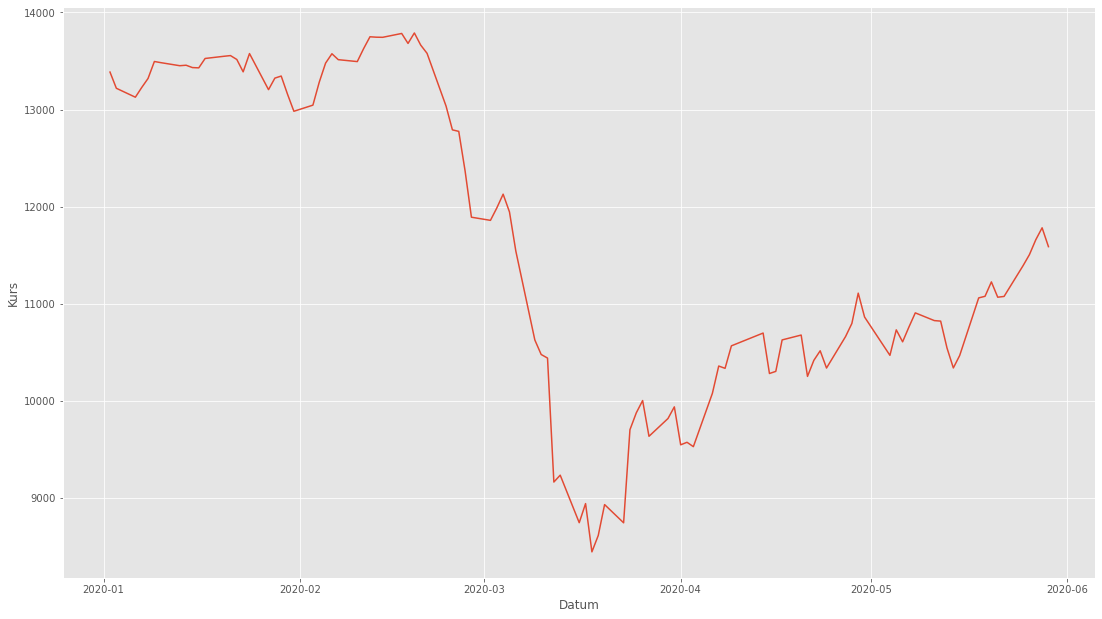

In [331]:
def get_date(entry):
    return entry["Date"]

# DAX
dax_data = list(map(lambda x: x.oRecordData, client.query('SELECT FROM ' + config.table_index_values_name + ' WHERE ISIN = "DE0008469008" AND Date > "2020-01-01" AND Date < "2020-06-01" ORDER BY Date ASC', -1)))
dax_data = sorted(dax_data, key=get_date)
dates = list([s["Date"] for s in dax_data])
close_values = list([s["Close"] for s in dax_data])
plt.plot(dates, close_values)
plt.xlabel('Datum')
plt.ylabel('Kurs')
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)
plt.show()

In [332]:
# # DAX
# dax_data = list(map(lambda x: x.oRecordData, client.query('SELECT FROM ' + config.table_index_values_name + ' WHERE ISIN = "DE0008469008" AND Date > "1998-01-01" ORDER BY Date ASC', -1)))
# dax_data = sorted(dax_data, key=get_date)
# dax_dates = list(map(lambda x: dt.datetime.strptime(x["Date"], '%Y-%m-%d').date(), dax_data))
# close_values = list(map(lambda x: x["Close"], dax_data))

# # CAC40
# cac_data = list(map(lambda x: x.oRecordData, client.query('SELECT FROM ' + config.table_index_values_name + ' WHERE ISIN = "FR0003500008" AND Date > "1998-01-01" ORDER BY Date ASC', -1)))
# cac_data = sorted(cac_data, key=get_date)
# cac_dates = list(map(lambda x: dt.datetime.strptime(x["Date"], '%Y-%m-%d').date(), cac_data))
# cac_close_values = list(map(lambda x: x["Close"], cac_data))

# # EZB
# ezb_data = list(map(lambda x: x.oRecordData, client.query('SELECT FROM ' + config.table_base_rates_name + ' WHERE Institution = "EZB" ORDER BY Date ASC', -1)))
# ezb_data = sorted(ezb_data, key=get_date_since)
# base_rate_dates = list(map(lambda x: dt.datetime.strptime(x["DateSince"], '%Y-%m-%d').date(), ezb_data))
# base_rate_values = list(map(lambda x: x["BaseRate"], ezb_data))

# fig, ax1 = plt.subplots()

# color = 'tab:red'
# ax1.set_xlabel('Datum')
# ax1.set_ylabel('Kurs (DAX)', color=color)
# ax1.plot(dax_dates, close_values, color=color)
# ax1.tick_params(axis='y', labelcolor=color)

# ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

# color = 'tab:blue'
# ax2.set_ylabel('Leitzins (EZB)', color=color)  # we already handled the x-label with ax1
# ax2.plot(base_rate_dates, base_rate_values, color=color)
# ax2.tick_params(axis='y', labelcolor=color)

# ax3 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

# color = 'tab:green'
# ax3.set_ylabel('Kurs (CAC40)', color=color)  # we already handled the x-label with ax1
# ax3.plot(cac_dates, cac_close_values, color=color)
# ax3.tick_params(axis='y', labelcolor=color)

# fig.tight_layout()  # otherwise the right y-label is slightly clipped
# fig.set_size_inches(18.5, 10.5)
# plt.show()

In [333]:
# # Dow Jones Industrial
# dji_data = list(map(lambda x: x.oRecordData, client.query('SELECT FROM ' + config.table_index_values_name + ' WHERE ISIN = "US2605661048" AND Date > "2000-01-01" AND Date < "2021-05-01" ORDER BY Date ASC', -1)))
# dji_data = sorted(dji_data, key=get_date)
# dji_dates = list(map(lambda x: dt.datetime.strptime(x["Date"], '%Y-%m-%d').date(), dji_data))
# dji_close_values = list(map(lambda x: x["Close"], dji_data))

# # S&P 500
# sp_data = list(map(lambda x: x.oRecordData, client.query('SELECT FROM ' + config.table_index_values_name + ' WHERE ISIN = "US78378X1072" AND Date > "2000-01-01" AND Date < "2021-05-01" ORDER BY Date ASC', -1)))
# sp_data = sorted(sp_data, key=get_date)
# sp_dates = list(map(lambda x: dt.datetime.strptime(x["Date"], '%Y-%m-%d').date(), sp_data))
# sp_close_values = list(map(lambda x: x["Close"], sp_data))

# # FED
# fed_data = list(map(lambda x: x.oRecordData, client.query('SELECT FROM ' + config.table_base_rates_name + ' WHERE Institution = "FED" ORDER BY Date ASC', -1)))
# fed_data = sorted(fed_data, key=get_date_since)
# base_rate_dates = list(map(lambda x: dt.datetime.strptime(x["DateSince"], '%Y-%m-%d').date(), fed_data))
# base_rate_values = list(map(lambda x: x["BaseRate"], fed_data))

# fig, ax1 = plt.subplots()

# color = 'tab:red'
# ax1.set_xlabel('Datum')
# ax1.set_ylabel('Kurs (DJI)', color=color)
# ax1.plot(dji_dates, dji_close_values, color=color)
# ax1.tick_params(axis='y', labelcolor=color)

# ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

# color = 'tab:blue'
# ax2.set_ylabel('Leitzins (FED)', color=color)  # we already handled the x-label with ax1
# ax2.plot(base_rate_dates, base_rate_values, "-o", color=color)
# ax2.tick_params(axis='y', labelcolor=color)

# ax3 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

# color = 'tab:green'
# ax3.set_ylabel('Kurs (S&P 500)', color=color)  # we already handled the x-label with ax1
# ax3.plot(sp_dates, sp_close_values, color=color)
# ax3.tick_params(axis='y', labelcolor=color)

# fig.tight_layout()  # otherwise the right y-label is slightly clipped
# fig.set_size_inches(18.5, 10.5)
# plt.show()

In [334]:
# sp_data = list(map(lambda x: x.oRecordData, client.query('SELECT FROM ' + config.table_index_values_name + ' WHERE ISIN = "US78378X1072" AND Date > "1998-01-01" ORDER BY Date ASC', -1)))
# sp_data = sorted(sp_data, key=get_date)
# sp_dates = list(map(lambda x: dt.datetime.strptime(x["Date"], '%Y-%m-%d').date(), sp_data))

# # S&P 500 Volume
# sp_volume_values = list(map(lambda x: x["Volume"], sp_data))

# # S&P 500 Close Values
# sp_close_values = list(map(lambda x: x["Close"], sp_data))

# # FED
# fed_data = list(map(lambda x: x.oRecordData, client.query('SELECT FROM ' + config.table_base_rates_name + ' WHERE Institution = "FED" ORDER BY Date ASC', -1)))
# fed_data = sorted(fed_data, key=get_date_since)
# base_rate_dates = list(map(lambda x: dt.datetime.strptime(x["DateSince"], '%Y-%m-%d').date(), fed_data))
# base_rate_values = list(map(lambda x: x["BaseRate"], fed_data))

# fig, ax1 = plt.subplots()

# color = 'tab:red'
# ax1.set_xlabel('Datum')
# ax1.set_ylabel('Kurs (DJI)', color=color)
# ax1.plot(sp_dates, sp_volume_values, color=color)
# ax1.tick_params(axis='y', labelcolor=color)

# ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

# color = 'tab:blue'
# ax2.set_ylabel('Leitzins (FED)', color=color)  # we already handled the x-label with ax1
# ax2.plot(base_rate_dates, base_rate_values, "-o", color=color)
# ax2.tick_params(axis='y', labelcolor=color)

# ax3 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

# color = 'tab:green'
# ax3.set_ylabel('Kurs (S&P 500)', color=color)  # we already handled the x-label with ax1
# ax3.plot(sp_dates, sp_close_values, color=color)
# ax3.tick_params(axis='y', labelcolor=color)

# fig.tight_layout()  # otherwise the right y-label is slightly clipped
# fig.set_size_inches(18.5, 10.5)
# plt.show()

In [335]:
class IndexRateDay(object):
    def __init__(self, date=None, open=None, high=None, low=None, close=None, adj_close=None, volume=None, isin=None, region=None):
        self.date = date
        self.open = open
        self.high = high
        self.low = low
        self.close = close
        self.adj_close = adj_close
        self.volume = volume
        self.isin = isin
        self.region = region

class WeekdayStatistic(object):
    def __init__(self, weekday=None, count=None, days_positive=None, days_negative=None, total_positive=None, total_negative=None):
        self.weekday = weekday
        self.count = count
        self.days_positive = days_positive
        self.days_negative = days_negative
        self.total_positive = total_positive
        self.total_negative = total_negative
        self.days_ratio = (days_positive / np.float64(days_negative))
        self.total_ratio = (total_positive / np.float64(-total_negative))
        
        
# DAX
dax_daily_values = list(map(lambda x: IndexRateDay(x["Date"], x["Open"], x["High"], x["Low"], x["Close"], x["Adj_Close"], x["Volume"], x["ISIN"], x["Region"]), dax_data))

res = defaultdict(list)
for s in dax_daily_values: res[s.date.weekday()].append(s)

day_names= ['Mondays', 'Tuesdays', 'Wednesdays', 'Thursdays', 'Fridays']

# Print number of trading days per weekday
for k, v in dict(sorted(res.items())).items():
    print(day_names[k] + ": " + str(len(v)))

def count_days_by_weekday(data, weekday):
    return len([s for s in data if s.date.weekday() == weekday])

def count_days(data, weekday, count_positive):
    last_close = 0
    days = 0
    
    for d in sorted(data, key=operator.attrgetter('date')):
        if d.date.weekday() == weekday:
            curr_value = d.adj_close - last_close if last_close != 0 else d.adj_close - d.open

            if count_positive and curr_value >= 0:
                days += 1
            elif not count_positive and curr_value < 0:
                days += 1
        
        last_close = d.adj_close
        
    return days
    
def sum_change(data, weekday, positive_change):
    last_close = 0
    value = 0
    
    for d in sorted(data, key=operator.attrgetter('date')):
        if d.date.weekday() == weekday:
            curr_value = d.adj_close - last_close if last_close != 0 else d.adj_close - d.open

            if positive_change and curr_value >= 0:
                value += curr_value
            elif not positive_change and curr_value < 0:
                value += curr_value
        
        last_close = d.adj_close
        
    return value
    
def query_data(isin, start_date, end_date):
    result = list(map(lambda x: x.oRecordData, client.query('SELECT FROM ' + config.table_index_values_name + ' WHERE ISIN = "' + isin + '" AND Date > "' + start_date + '" AND Date < "' + end_date + '" ORDER BY Date ASC', -1)))
    result = sorted(result, key=get_date)
    return list([IndexRateDay(x["Date"], x["Open"], x["High"], x["Low"], x["Close"], x["Adj_Close"], x["Volume"], x["ISIN"], x["Region"]) for x in result])
    
def create_weekday_statistic(data):
    return list([
        WeekdayStatistic(i, count_days_by_weekday(data, i), count_days(data, i, True), count_days(data, i, False), sum_change(data, i, True), sum_change(data, i, False))
        for i 
        in range(0, 5)
    ])
    
weekday_statistics = create_weekday_statistic(dax_daily_values)

display([s.__dict__ for s in weekday_statistics])

total = 0
total_days = 0
total_days_pos_neg = 0

for s in weekday_statistics:
    total += s.total_positive + s.total_negative
    total_days += s.count
    total_days_pos_neg += s.days_positive + s.days_negative
    assert s.count == (s.days_positive + s.days_negative)
    
dax_daily_length = len(dax_daily_values)

print("Total change: " + str(total))
print("Total change (simple calculation): " + str(dax_daily_values[dax_daily_length - 1].adj_close - dax_daily_values[0].open))
print("Total days (sum of count): " + str(total_days))
print("Total days (positive and negative combined): " + str(total_days_pos_neg))
print("Total days (simple calculation): " + str(len(dax_daily_values)))

5939


TypeError: strptime() argument 1 must be str, not datetime.date

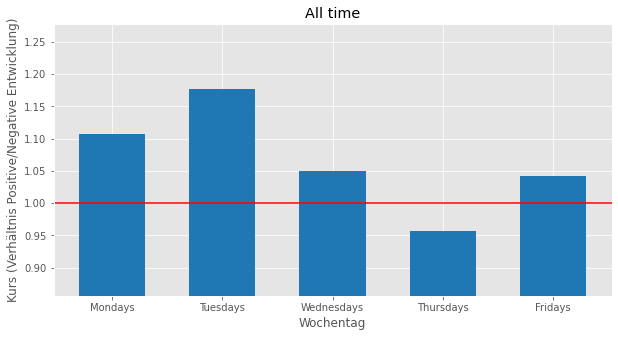

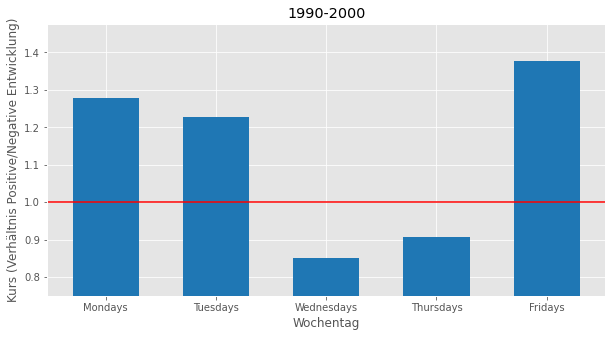

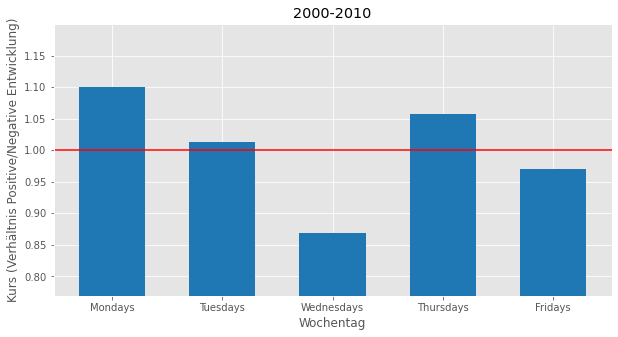

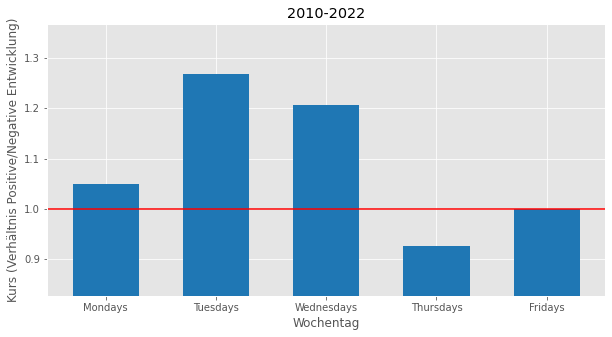

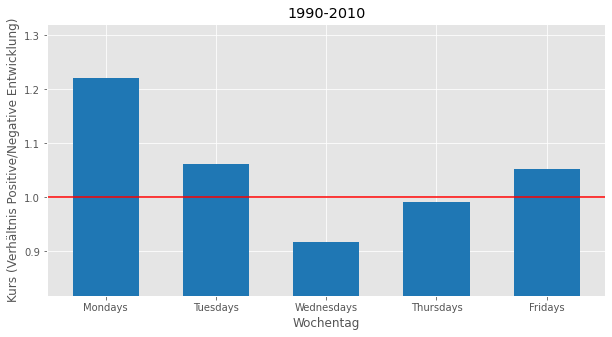

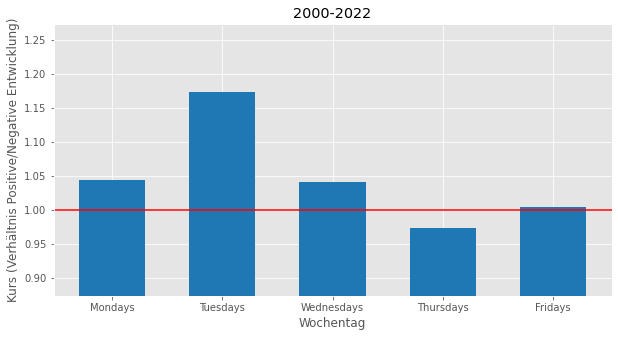

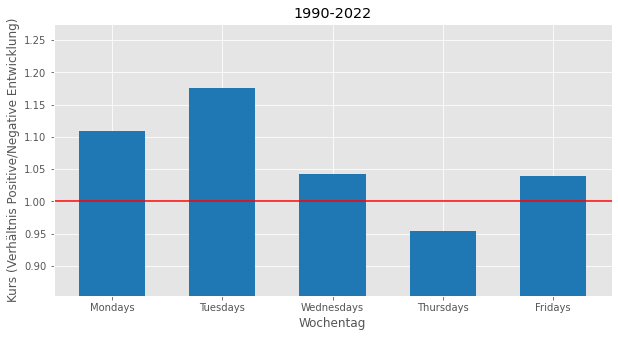

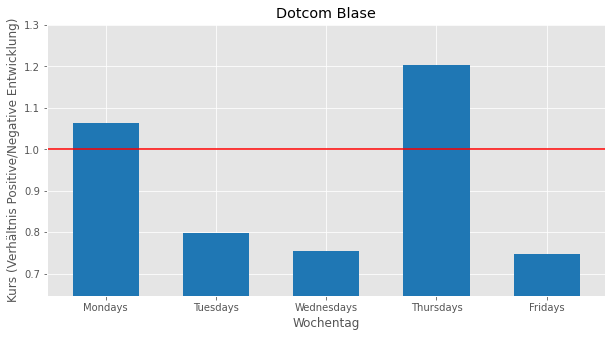

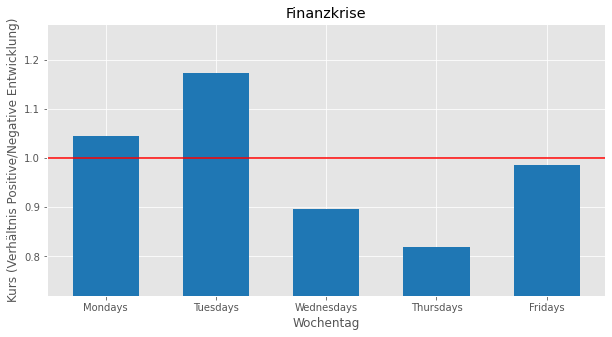

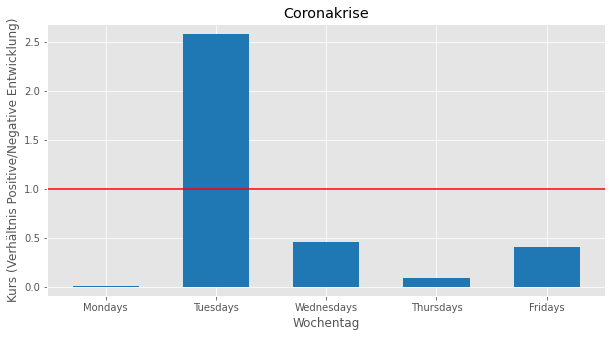

In [309]:
class TimeRange(object):
    def __init__(self, name=None, start=None, end=None):
        self.name = name
        self.start = start
        self.end = end
        
time_ranges = [
    TimeRange("All time", "1975-01-01", "2022-12-31"), 
    TimeRange("1990-2000", "1990-01-01", "2000-12-31"), 
    TimeRange("2000-2010", "2000-01-01", "2010-12-31"), 
    TimeRange("2010-2022", "2010-01-01", "2022-12-31"), 
    TimeRange("1990-2010", "1990-01-01", "2010-12-31"), 
    TimeRange("2000-2022", "2000-01-01", "2022-12-31"), 
    TimeRange("Dotcom Blase", "2001-01-01", "2003-12-31"),
    TimeRange("Finanzkrise", "2007-01-01", "2009-12-31"),
    TimeRange("Coronakrise", "2020-02-15", "2020-03-25"),
]

for t in time_ranges:
    data = query_data("DE0008469008", t.start, t.end)
    weekday_statistic = create_weekday_statistic(data)
    day_names = ['Mondays', 'Tuesdays', 'Wednesdays', 'Thursdays', 'Fridays']
    
    plt_x = list([day_names[s.weekday] for s in weekday_statistic])
    plt_values = list([s.total_ratio for s in weekday_statistic])

    y_min = min(plt_values) - 0.1
    y_max = max(plt_values) + 0.1
    
    fig = plt.figure(figsize = (10, 5))

    plt.bar(plt_x, plt_values, color = 'tab:blue', width = 0.6)

    plt.ylim(y_min, y_max)
    plt.axhline(y=1, color='r', linestyle='-')
    plt.xlabel("Wochentag")
    plt.ylabel("Kurs (Verhältnis Positive/Negative Entwicklung)")
    plt.title(t.name)
    plt.show()